# FCN 2D para detecção de cicatrizes de queimadas

Para resolver o problema de detecção de cicatrizes, utilizamos uma arquitetura baseada em **Fully Convolutional Networks (FCN)**, inspirada na abordagem proposta por [Zeng et al. (2025)](https://www.kaggle.com/datasets/xiaoweixumedicalai/imagecas). A arquitetura original foi desenvolvida para segmentação em tomografias tridimensionais, com apenas **1 canal de entrada**. Empregamos uma adaptação que permite processar **imagens bidimensionais com 8 canais de entrada**, correspondentes às bandas espectrais dos pares temporais (T1 e T2), ajustando o modelo às características dos dados de sensoriamento remoto.


Equipe:
- Everaldina Guimarães Barbosa (everaldinag@gmail.com)
- Esbel Tomás Valero Orellana (evalero@uesc.br)

Universidade Estadual de Santa Cruz (UESC) - Ilhéus, Bahia, Brasil


## Requesitos

O codigo foi desenvolvido em python 3.12 utilizando pytorch, abaixo o conteúdo do arquivo requirements.txt

```
affine==2.4.0
asttokens==3.0.0
attrs==25.3.0
certifi==2025.8.3
click==8.2.1
click-plugins==1.1.1.2
cligj==0.7.2
comm==0.2.3
contourpy==1.3.3
cycler==0.12.1
debugpy==1.8.16
decorator==5.2.1
executing==2.2.1
filelock==3.19.1
fonttools==4.59.2
fsspec==2025.7.0
ipykernel==6.30.1
ipython==9.5.0
ipython_pygments_lexers==1.1.1
jedi==0.19.2
Jinja2==3.1.6
joblib==1.5.2
jupyter_client==8.6.3
jupyter_core==5.8.1
kiwisolver==1.4.9
MarkupSafe==3.0.2
matplotlib==3.10.6
matplotlib-inline==0.1.7
mpmath==1.3.0
nest-asyncio==1.6.0
networkx==3.5
numpy==2.3.2
nvidia-cublas-cu12==12.8.4.1
nvidia-cuda-cupti-cu12==12.8.90
nvidia-cuda-nvrtc-cu12==12.8.93
nvidia-cuda-runtime-cu12==12.8.90
nvidia-cudnn-cu12==9.10.2.21
nvidia-cufft-cu12==11.3.3.83
nvidia-cufile-cu12==1.13.1.3
nvidia-curand-cu12==10.3.9.90
nvidia-cusolver-cu12==11.7.3.90
nvidia-cusparse-cu12==12.5.8.93
nvidia-cusparselt-cu12==0.7.1
nvidia-nccl-cu12==2.27.3
nvidia-nvjitlink-cu12==12.8.93
nvidia-nvtx-cu12==12.8.90
packaging==25.0
pandas==2.3.2
parso==0.8.5
pexpect==4.9.0
pillow==11.3.0
platformdirs==4.4.0
prompt_toolkit==3.0.52
psutil==7.0.0
ptyprocess==0.7.0
pure_eval==0.2.3
Pygments==2.19.2
pyparsing==3.2.3
python-dateutil==2.9.0.post0
pytz==2025.2
pyzmq==27.0.2
rasterio==1.4.3
scikit-learn==1.7.1
scipy==1.16.1
setuptools==80.9.0
six==1.17.0
stack-data==0.6.3
sympy==1.14.0
threadpoolctl==3.6.0
torch==2.8.0
tornado==6.5.2
traitlets==5.14.3
triton==3.4.0
typing_extensions==4.15.0
tzdata==2025.2
wcwidth==0.2.13
```

## Rede

Esse é o codigo para a FCN de segmentação de imagens 2D. Sua arquitetura encoder-decoder é construída a partir de blocos Unet e utiliza skip connections para combinar características de diferentes escalas.

In [1]:
import torch as th
import torch.nn as nn

class Unet_module(nn.Module):
    def __init__(self, kernel_size, de_kernel_size, channel_list, down_up='down'):
        super(Unet_module, self).__init__()
        self.conv1 = nn.Conv2d(channel_list[0], channel_list[1], kernel_size, 1, (kernel_size - 1) // 2)
        self.conv2 = nn.Conv2d(channel_list[1], channel_list[2], kernel_size, 1, (kernel_size - 1) // 2)
        self.relu1 = nn.PReLU()
        self.relu2 = nn.PReLU()
        self.bn1 = nn.BatchNorm2d(channel_list[1])
        self.bn2 = nn.BatchNorm2d(channel_list[2])
        self.bridge_conv = nn.Conv2d(channel_list[0], channel_list[-1], kernel_size, 1, (kernel_size - 1) // 2)

        if down_up == 'down':
            self.sample = nn.Sequential(
                nn.Conv2d(channel_list[2], channel_list[2], de_kernel_size, 2, (de_kernel_size - 1) // 2, 1),
                nn.BatchNorm2d(channel_list[2]), nn.PReLU())
        else:
            self.sample = nn.Sequential(
                nn.ConvTranspose2d(channel_list[2], channel_list[2], de_kernel_size, 2, (de_kernel_size - 1) // 2),
                nn.BatchNorm2d(channel_list[2]), nn.ReLU())

    def forward(self, x):
        res = self.bridge_conv(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = x + res
        next_layer = self.sample(x)

        return next_layer, x
    
class de_conv_module(nn.Module):
    def __init__(self, kernel_size, de_kernel_size, channel_list, down_up='down'):
        super().__init__()
        self.conv1 = nn.Conv2d(channel_list[0], channel_list[1], kernel_size, 1, (kernel_size - 1) // 2)
        self.conv2 = nn.Conv2d(channel_list[1], channel_list[2], kernel_size, 1, (kernel_size - 1) // 2)
        self.relu1 = nn.PReLU()
        self.relu2 = nn.PReLU()
        self.bn1 = nn.BatchNorm2d(channel_list[1])
        self.bn2 = nn.BatchNorm2d(channel_list[2])
        self.bridge_conv = nn.Conv2d(channel_list[0], channel_list[-1], kernel_size, 1, (kernel_size - 1) // 2)

        if down_up == 'down':
            self.sample = nn.Sequential(
                nn.Conv2d(channel_list[2], channel_list[2], de_kernel_size, 2, (de_kernel_size - 1) // 2, 1),
                nn.BatchNorm2d(channel_list[2]), nn.PReLU())
        else:
            self.sample = nn.Sequential(
                nn.ConvTranspose2d(channel_list[2], channel_list[2], de_kernel_size, 2, (de_kernel_size - 1) // 2),
                nn.BatchNorm2d(channel_list[2]), nn.ReLU())

    def forward(self, x, x1):
        x = th.cat([x, x1], dim=1)
        res = self.bridge_conv(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = x + res
        next_layer = self.sample(x)

        return next_layer

class FCN_2D(nn.Module):
    def __init__(self, in_channel, layers):
        super().__init__()
        # channel=2
        self.conv1 = nn.Sequential(nn.Conv2d(in_channel, layers, 5, 1, padding=2), nn.BatchNorm2d(layers), nn.PReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(layers, layers * 2, 2, 2, padding=0), nn.BatchNorm2d(layers * 2),
                                   nn.PReLU())
        self.conv3 = Unet_module(5, 2, [layers * 2, layers * 2, layers * 4], 'down')
        self.conv4 = Unet_module(5, 2, [layers * 4, layers * 4, layers * 8], 'down')
        self.conv5 = Unet_module(5, 2, [layers * 8, layers * 8, layers * 16], 'down')

        self.de_conv1 = Unet_module(5, 2, [layers * 16, layers * 32, layers * 16], down_up='up')
        self.de_conv2 = de_conv_module(5, 2, [layers * 32, layers * 8, layers * 8], down_up='up')
        self.de_conv3 = de_conv_module(5, 2, [layers * 16, layers * 4, layers * 4], down_up='up')
        self.de_conv4 = de_conv_module(5, 2, [layers * 8, layers * 2, layers], down_up='up')

        self.last_conv = nn.Conv2d(layers * 2, 1, 1, 1, padding=0)

    def forward(self, x):
        x = self.conv1(x)
        x_1 = x
        x = self.conv2(x)
        x, x_2 = self.conv3(x)
        x, x_3 = self.conv4(x)
        x, x_4 = self.conv5(x)

        x, _ = self.de_conv1(x)
        x = self.de_conv2(x, x_4)
        x = self.de_conv3(x, x_3)
        x = self.de_conv4(x, x_2)

        x = th.cat([x, x_1], dim=1)
        output = self.last_conv(x)
        return output


## Dados

As imagens das pastas T1 e T2, com dimensões 4 × 128 × 128, foram combinadas ao longo do eixo de canais, formando entradas de rede com dimensão 8 × 128 × 128. A máscara de saída gerada pela rede possui dimensão 1 × 128 × 128.

O conjunto de dados foi dividido em 80% para treino e 20% para teste. Para controlar essa separação, foi criado um arquivo split_id.csv, que registra os recortes utilizados em cada subconjunto.

In [2]:
import pandas as pd

split_df = pd.read_csv('split_ids.csv')
train_ids = split_df[split_df['split'] == 'train']['ID'].to_list()
val_ids = split_df[split_df['split'] == 'val']['ID'].to_list()

print('--- Divisão do dataset ---')
print('Total de recortes: ', len(split_df))
print('Total de recortes de treino: ', len(train_ids))
print('Total de recortes de validação: ', len(val_ids))

print(f'Recortes de treino: {train_ids}')
print(f'Recortes de validação: {val_ids}')

--- Divisão do dataset ---
Total de recortes:  945
Total de recortes de treino:  756
Total de recortes de validação:  189
Recortes de treino: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 29, 30, 32, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 98, 99, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 125, 126, 128, 129, 130, 132, 133, 134, 135, 136, 137, 139, 140, 141, 143, 144, 146, 147, 148, 149, 151, 152, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170, 172, 174, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 212, 213, 214, 215, 216, 218, 219, 221, 222, 223, 225, 226, 227, 228, 230, 232, 233, 234, 235, 

In [3]:
from torch.utils.data import Dataset
import numpy as np
import os
import torch
import rasterio

class WorCapDataset(Dataset):
    def __init__(self, T10_dir, T20_dir, mask_dir, ids, transform=None):
        self.T10_dir = T10_dir
        self.T20_dir = T20_dir
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform
        
    def __len__(self):
        return len(self.ids)

    def read_image(self, path):
        with rasterio.open(path) as src:
            img = src.read().astype(np.float32)
            img = np.nan_to_num(img, nan=0.0)
            img_min = img.min()
            img_max = img.max()
            if img_max - img_min > 0:
                img = (img - img_min) / (img_max - img_min)
            else:
                img = np.zeros_like(img)
        return torch.tensor(img, dtype=torch.float32)

    def read_mask(self, path):
        with rasterio.open(path) as src:
            mask = src.read(1).astype(np.float32)
            mask = np.nan_to_num(mask, nan=0.0)
            mask = np.where(mask > 0, 1.0, 0.0)
        return torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

    def __getitem__(self, idx):
        id_ = self.ids[idx]
        fname = f"recorte_{id_}.tif"
        T10_path = os.path.join(self.T10_dir, fname)
        T20_path = os.path.join(self.T20_dir, fname)
        mask_path = os.path.join(self.mask_dir, fname)

        t1 = self.read_image(T10_path)
        t2 = self.read_image(T20_path)
        mask = self.read_mask(mask_path)

        if self.transform:
            t1 = self.transform(t1)
            t2 = self.transform(t2)
            mask = self.transform(mask)

        T = torch.cat([t1, t2], dim=0)
        return T, mask, id_

## Treino

Foi utilizado o otimizador de Adam com learning rate de 0.001, a função de perda utilizada foi o Dice Loss.

A fórmula matemática do Dice é similar ao F1-score, pois ambos medem a sobreposição entre a predição e o alvo:

$$
\text{Dice} = \frac{2\,|\text{Pred} \cap \text{GT}|}{|\text{Pred}| + |\text{GT}|}
$$

Pred é a predição do modelo e GT é o Ground Truth.

O Dice Loss é definido como $1 - \text{Dice}$, sendo especialmente útil para tarefas de segmentação.

Foi feito um treino por 100 épocas com batch size de 32. Foram avaliados 3 treinos com parametros distintos de layers na rede: 8, 32 e 64 layers. O melhor modelo obtido foi o de 32 layers.


In [4]:
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time

In [5]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs)
        N = inputs.size()[0]
        
        inputs = inputs.contiguous().view(N, -1)
        targets = targets.contiguous().view(N, -1)

        intersection = (inputs * targets).sum(1)
        dice = (2. * intersection + smooth) / (inputs.sum(1) + targets.sum(1) + smooth)

        return 1 - dice.sum() / N

In [6]:
channels = 8
layers = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
epochs = 100
batch_size = 32

In [7]:
def train(model, criterion, train_loader, opt, device, e):
    model = model.to(device)
    model.train()
    train_sum = 0
    for j, batch in enumerate(train_loader):
        img, label = batch[0].float(), batch[1].float()
        img, label = img.to(device), label.to(device)
        outputs = model(img)
        opt.zero_grad()
        loss = criterion(outputs, label)
        print('Epoch {:<3d}  |  Step {:>3d}/{:<3d}  | train loss {:.4f}'.format(e, j, len(train_loader), loss.item()))
        train_sum += loss.item()
        loss.backward()
        opt.step()
    return train_sum / len(train_loader)

In [8]:
def valid(model, criterion, valid_loader, device, e):
    model.eval()
    valid_sum = 0
    for j, batch in enumerate(valid_loader):
        img, label = batch[0].float(), batch[1].float()
        img, label = img.to(device), label.to(device)

        with torch.no_grad():
            outputs = model(img)
            loss = criterion(outputs, label)
        valid_sum += loss.item()
        print('Epoch {:<3d}  |Step {:>3d}/{:<3d}  | valid loss {:.4f}'.format(e, j, len(valid_loader), loss.item()))

    return valid_sum / len(valid_loader)

In [9]:
data_paths = {
        'T1': 'data/dataset/t1',
        'T2': 'data/dataset/t2',
        'mask': 'data/dataset/mask',
        'T1_avaliacao': 'data/avaliacao/t1',
        'T2_avaliacao': 'data/avaliacao/t2',
    }


In [10]:
# net = FCN_2D(channels, layers).to(device)


# for m in net.modules():
#    if isinstance(m, (nn.Conv3d)):
#        nn.init.orthogonal_(m.weight)


# net_opt = optim.Adam(net.parameters(), lr=learning_rate)
# criterion = DiceLoss()

# train_loss_set = []
# valid_loss_set = []
# epoch_list = []
# duration = []


# dataset_train = WorCapDataset(data_paths["T1"], data_paths["T2"], data_paths['mask'], train_ids)
# dataset_val = WorCapDataset(data_paths["T1"], data_paths["T2"], data_paths['mask'], val_ids)

# train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

result_path = os.path.abspath('.') + '/results'
model_save_path = os.path.join(result_path, f'FCN_2D_{channels}ch_{layers}lyr')

# for e in range(0, epochs):
#     time_start = time.time()
#     print("=============train=============")
#     train_loss = train(net, criterion, train_loader, net_opt, device, e)
#     print("=============valid=============")
#     valid_loss = valid(net, criterion, test_loader, device, e)

#     train_loss_set.append(train_loss)
#     valid_loss_set.append(valid_loss)
#     epoch_list.append(e)
#     print("train_loss:%f || valid_loss:%f" % (train_loss, valid_loss))
#     time_end = time.time()
#     duration.append(time_end - time_start)
    

# torch.save(net.state_dict(), model_save_path + '/net_%d.pkl' % (e+1))
        
# record = dict()
# record['epoch'] = epoch_list
# record['train_loss'] = train_loss_set
# record['valid_loss'] = valid_loss_set
# record['duration'] = duration
# record = pd.DataFrame(record)
# record.to_csv(os.path.join(model_save_path, 'train_record.csv'), index=False)

O modelo de de 32 layers finalizou os treinamentos com loss de 0.07155 no conjunto de treino e .17407 no conjunto de teste. O treinamento ocorreu em 18 minutos.

In [11]:
import matplotlib.pyplot as plt

In [12]:
root_folder = os.getcwd()
train_name = f'FCN_2D_{channels}ch_{layers}lyr'
file_path = os.path.join(root_folder, 'results', train_name)
csv_train = pd.read_csv(os.path.join(file_path, 'train_record.csv'))

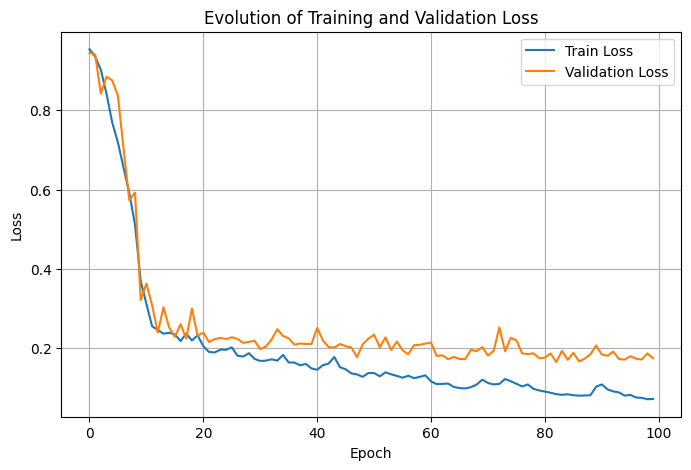

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(csv_train['epoch'], csv_train['train_loss'], label='Train Loss')
plt.plot(csv_train['epoch'], csv_train['valid_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Evolution of Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [14]:
total_duration = sum(csv_train['duration'])
formated_duration = time.strftime("%H:%M:%S", time.gmtime(total_duration))
print(f'Total training duration: {formated_duration} (HH:MM:SS)')

Total training duration: 00:18:50 (HH:MM:SS)


###  Avaliação

In [15]:
import pickle
from sklearn.metrics import roc_auc_score, roc_curve

In [16]:
def read_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

In [17]:
def read_mask(path):
    with rasterio.open(path) as src:
        mask = src.read(1).astype(np.float32)
        mask = np.nan_to_num(mask, nan=0.0)
        mask = np.where(mask > 0, 1.0, 0.0)
    return mask

In [18]:
def calc_dice(labels, preds):
    labels_flat = labels.flatten()
    preds_flat = preds.flatten()
    
    labels_flat = labels_flat.astype(bool).astype(int)
    preds_flat = preds_flat.astype(bool).astype(int)
    
    intersection = np.sum(labels_flat * preds_flat)
    union = np.sum(labels_flat) + np.sum(preds_flat)
    
    if union == 0:
        return 1.0 # sem labels em ambos, ou seja, predição perfeita
    else:
        return (2. * intersection) / union

In [19]:
dices = {}

train_name = f'FCN_2D_{channels}ch_{layers}lyr'
file_path = os.path.join(root_folder, 'results', train_name, 'infer')


all_labels = []
all_preds = []

dices[f'{layers}_layers'] =  {}
dices[f'numero_mask'] =  {}

for r in val_ids:
    mask = read_mask(os.path.join(data_paths['mask'], f'recorte_{r}.tif'))
    pickle_pred = read_pickle(os.path.join(file_path, f'recorte_{r}.pkl'))
    pred = np.array(pickle_pred).squeeze()
    
    num_mask = np.sum(mask)
    dices[f'numero_mask'][r] = num_mask
    
    pred_binary = (pred >= 0.5).astype(np.float32)
    dice = calc_dice(mask, pred_binary)
    dices[f'{layers}_layers'][r] = dice 
    
    
    # Flatten para usar no ROC
    all_labels.extend(mask.ravel())
    all_preds.extend(pred.ravel())

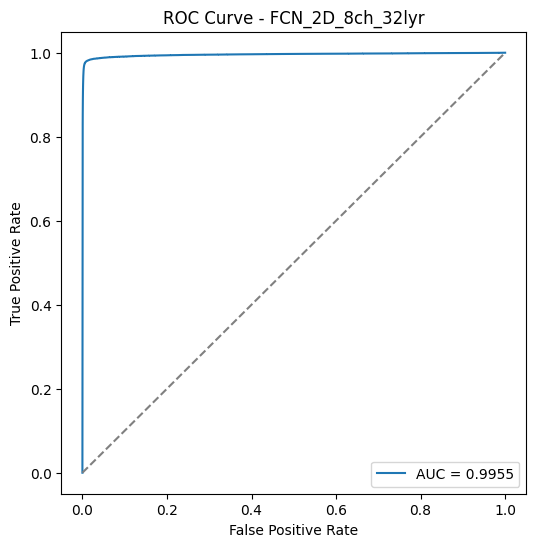

In [20]:
labels = np.array(all_labels)
preds = np.array(all_preds)
auc = roc_auc_score(labels, preds)
fpr, tpr, thresholds = roc_curve(labels, preds)

# print(f"AUC-ROC: {auc:.4f}")

# --- Plotar curva ROC ---
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {train_name}")
plt.legend()
plt.show()

Além da curva ROC, também foi calculado o coeficiente de Dice no conjunto de teste. Observou-se que o valor do Dice para imagens sem máscara de cicatriz foi significativamente superior ao valor obtido para imagens com máscara. Por esse motivo, foram reportados três valores distintos: o Dice geral, o Dice para imagens sem máscara e o Dice para imagens com máscara.

In [21]:
def plot_histograms(df, column, title):
    median_dice = df[column].median()
    mean_dice = df[column].mean()
    first_quartile = df[column].quantile(0.25)
    third_quartile = df[column].quantile(0.75)
    
    plt.figure(figsize=(8, 5))
    plt.hist(df[column], bins=20, edgecolor='black', color='#0072B2')  # blue
    plt.title(title)
    plt.xlabel('Dice')
    plt.ylabel('Frequência')
    plt.axvline(median_dice, color='#D55E00', linestyle='dashed', linewidth=1, label=f'Mediana ({median_dice:.3f})')  # vermelha/laranja
    plt.axvline(mean_dice, color='#009E73', linestyle='dashed', linewidth=1, label=f'Média ({mean_dice:.3f})')  # verde
    plt.axvline(first_quartile, color='#CC79A7', linestyle='dashed', linewidth=1, label=f'1º Quartil ({first_quartile:.3f})')  # magenta
    plt.axvline(third_quartile, color='#F0E442', linestyle='dashed', linewidth=1, label=f'3º Quartil ({third_quartile:.3f})')  # amarelo
    
    
    plt.legend()
    plt.show()

In [22]:
df_dices = pd.read_csv('dices_infer.csv')
df_no_mask = df_dices[df_dices['numero_mask'] == 0]
df_mask = df_dices[df_dices['numero_mask'] > 0]
column = f'{layers}_layers_{channels}channels'

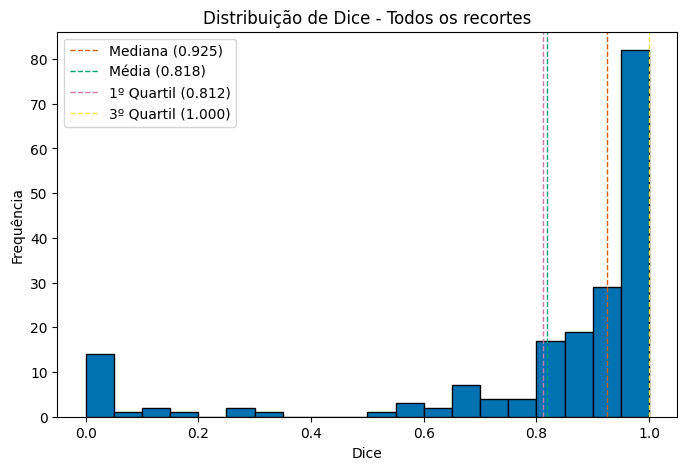

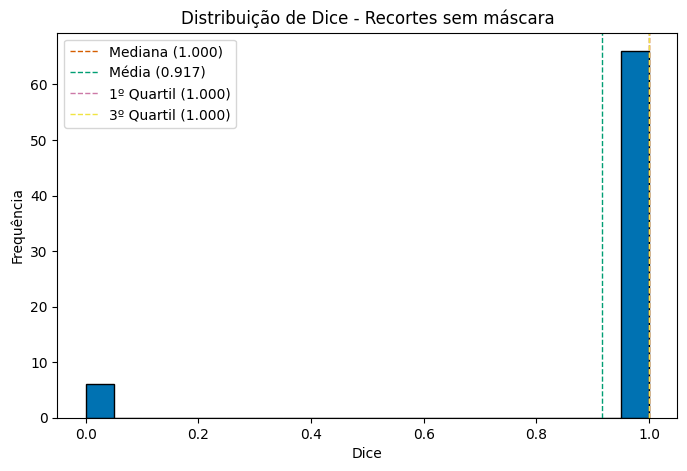

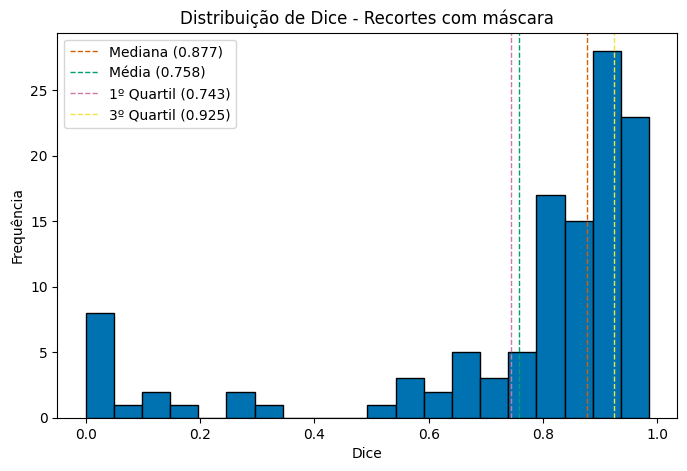

In [23]:
plot_histograms(df_dices, column, 'Distribuição de Dice - Todos os recortes')
plot_histograms(df_no_mask, column, 'Distribuição de Dice - Recortes sem máscara')
plot_histograms(df_mask, column, 'Distribuição de Dice - Recortes com máscara')

In [24]:

desc_total = df_dices[column].describe().rename('Todos')
desc_no_mask = df_no_mask[column].describe().rename('Sem máscara')
desc_mask = df_mask[column].describe().rename('Com máscara')

df_describe = pd.concat([desc_total, desc_no_mask, desc_mask], axis=1)
df_describe


,Todos,Sem máscara,Com máscara
count,189.000000,72.000000,117.000000
mean,0.818164,0.916667,0.757548
std,0.288402,0.278325,0.278674
min,0.000000,0.000000,0.000000
25%,0.811594,1.000000,0.743363
50%,0.925373,1.000000,0.877323
75%,1.000000,1.000000,0.924545
max,1.000000,1.000000,0.985646


## Visualização dos resultados

In [25]:
import random

In [26]:
def get_best_worst_ids(df, column, id_col='recorte', n=10):
    sorted_df = df.sort_values(by=column)
    worst_ids = sorted_df.head(n)[id_col].tolist()
    best_ids = sorted_df.tail(n)[id_col].tolist()
    return best_ids, worst_ids

best_no_mask, worst_no_mask = get_best_worst_ids(df_no_mask, column)
best_mask, worst_mask = get_best_worst_ids(df_mask, column)

samples = [
    random.choice(best_no_mask),
    random.choice(worst_no_mask),
    *random.sample(best_mask, 3),
    *random.sample(worst_mask, 3)
]

In [27]:
def plot_sample(t1, t2, mask, pred, title):
    # Selecionar 3 bandas (ex: primeiras 3 para simular RGB)
    t1_rgb = np.transpose(t1[:3], (1, 2, 0))
    t2_rgb = np.transpose(t2[:3], (1, 2, 0))
    mask_img = mask
    pred_img = pred


    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    axs[0].imshow(t1_rgb)
    axs[0].set_title("T1 (RGB falso)")
    axs[1].imshow(t2_rgb)
    axs[1].set_title("T2 (RGB falso)")
    axs[2].imshow(mask_img, cmap="gray")
    axs[2].set_title("Mask")
    axs[3].imshow(pred_img, cmap="gray")
    axs[3].set_title("Pred")
    for ax in axs:
        ax.axis('off')
    plt.suptitle(title)
    plt.show()


In [28]:
def read_image(path):
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32)
        img = np.nan_to_num(img, nan=0.0)
        img_min = img.min()
        img_max = img.max()
        if img_max - img_min > 0:
            img = (img - img_min) / (img_max - img_min)
        else:
            img = np.zeros_like(img)
    return img

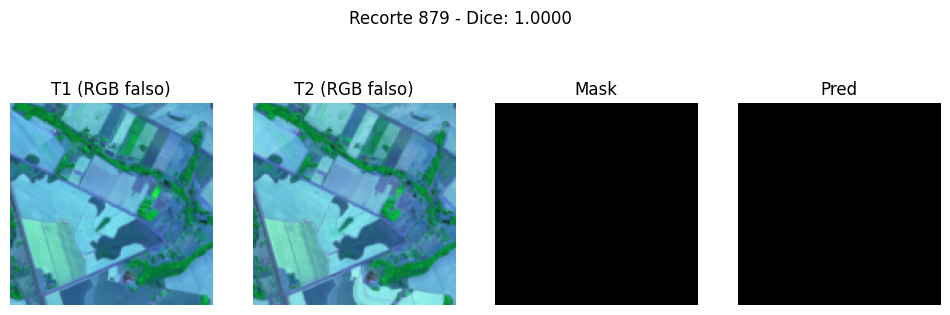

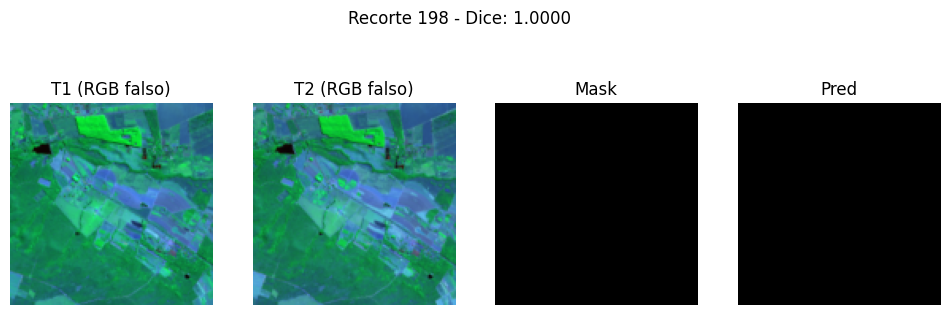

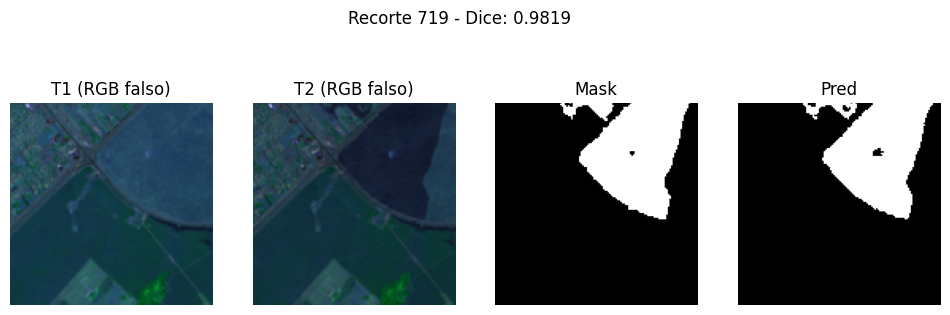

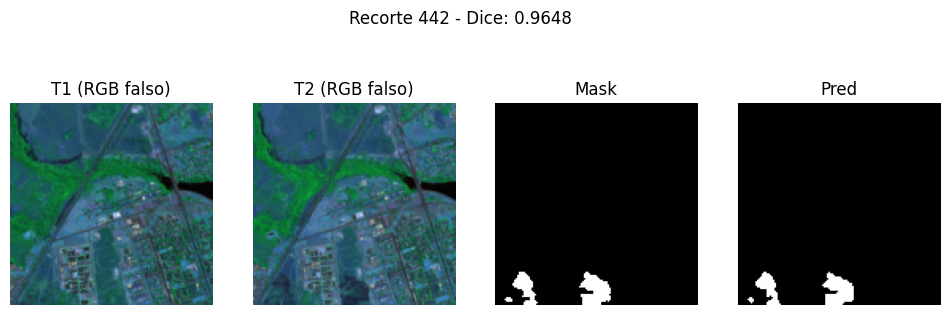

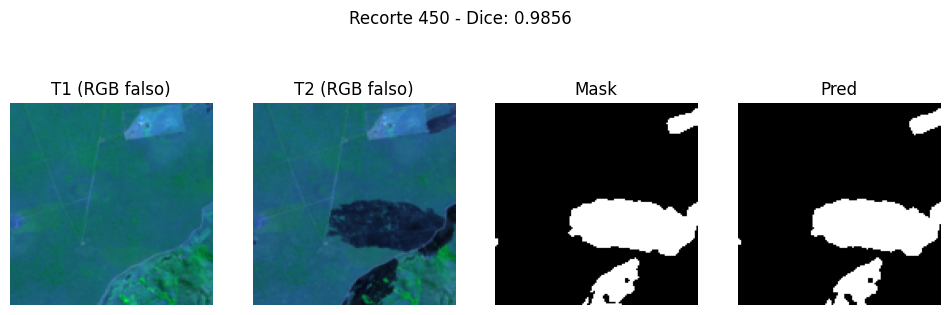

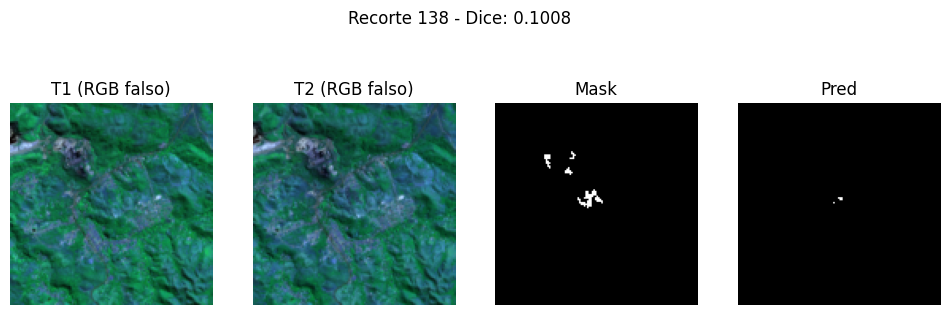

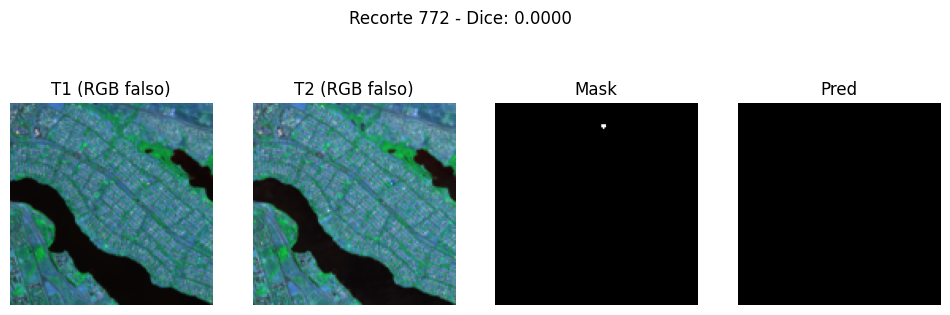

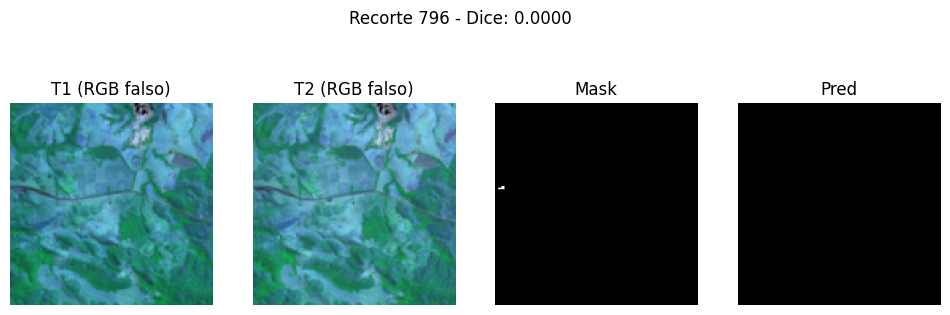

In [29]:

train_name = f'FCN_2D_{channels}ch_{layers}lyr'
file_path = os.path.join(root_folder, 'results', train_name, 'infer')

for sample in samples:
    mask = read_mask(os.path.join(data_paths['mask'], f'recorte_{sample}.tif'))
    pickle_pred = read_pickle(os.path.join(file_path, f'recorte_{sample}.pkl'))
    pred_binary = (pickle_pred >= 0.5).astype(np.float32)
    
    t1 = read_image(os.path.join(data_paths['T1'], f'recorte_{sample}.tif'))
    t2 = read_image(os.path.join(data_paths['T2'], f'recorte_{sample}.tif'))
    plot_sample(t1, t2, mask, pred_binary[0], f'Recorte {sample} - Dice: {dices[f"{layers}_layers"][sample]:.4f}')

## Predição para submissão do hackathon

In [30]:
class WorCapDatasetInfer(Dataset):
    def __init__(self, T10_dir, T20_dir, transform=None):
        self.T10_dir = T10_dir
        self.T20_dir = T20_dir
        self.ids = sorted([
            f.split('_')[-1].replace('.tif', '')
            for f in os.listdir(T10_dir)
            if f.startswith('recorte_') and
               os.path.isfile(os.path.join(T20_dir, f))
        ])
        self.transform = transform
        
    def __len__(self):
        return len(self.ids)

    def read_image(self, path):
        with rasterio.open(path) as src:
            img = src.read().astype(np.float32)
            img = np.nan_to_num(img, nan=0.0)
            img_min = img.min()
            img_max = img.max()
            if img_max - img_min > 0:
                img = (img - img_min) / (img_max - img_min)
            else:
                img = np.zeros_like(img)
        return torch.tensor(img, dtype=torch.float32)

    def __getitem__(self, idx):
        id_ = self.ids[idx]
        fname = f"recorte_{id_}.tif"
        T10_path = os.path.join(self.T10_dir, fname)
        T20_path = os.path.join(self.T20_dir, fname)

        t1 = self.read_image(T10_path)
        t2 = self.read_image(T20_path)

        if self.transform:
            t1 = self.transform(t1)
            t2 = self.transform(t2)

        T = torch.cat([t1, t2], dim=0)
        return T, id_

In [31]:
limiar_selected = [0.00005, 0.15, 0.2, 0.25, 0.1, 0.3, 0.4, 0.4850 ,0.5, 0.6]
limiar = 0.1

In [32]:
import os
import torch
import csv
import numpy as np
from torch.utils.data import DataLoader

# Configuração
load_num = 100
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
torch.cuda.set_device(0)
torch.backends.cudnn.enabled = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset e DataLoader
dataset_val = WorCapDatasetInfer(data_paths["T1_avaliacao"], data_paths["T2_avaliacao"])
test_loader = DataLoader(dataset_val, batch_size=1, shuffle=False)


print("Carregando modelo da pasta:", model_save_path)
net = FCN_2D(channels, layers).to(device)
net.load_state_dict(torch.load(model_save_path + '/net_%d.pkl' % load_num))
net.eval()


csv_path = f"submission_{limiar}l.csv"


with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)

    for i, batch in enumerate(test_loader):
        img, id_tensor = batch
        img = img.to(device).float()

        with torch.no_grad():
            output = net(img)
            output = torch.sigmoid(output)

        output = output.squeeze().cpu().numpy()
        pred_mask = (output > limiar).astype(int).flatten()

        if i == 0:
            num_pixels = pred_mask.shape[0]
            header = ["id"] + [f"pixel_{j}" for j in range(num_pixels)]
            writer.writerow(header)

        
        sample_id = f'recorte_{str(id_tensor[0])}.tif'

        
        row = [sample_id] + pred_mask.tolist()
        writer.writerow(row)

print(f"✅ CSV salvo com as máscaras preditas: {csv_path}")

Carregando modelo da pasta: /home/everaldina/Documentos/workspace/WorCap 2025/results/FCN_2D_8ch_32lyr
✅ CSV salvo com as máscaras preditas: submission_0.1l.csv


In [33]:
df = pd.read_csv(csv_path)
df

,id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_16374,pixel_16375,pixel_16376,pixel_16377,pixel_16378,pixel_16379,pixel_16380,pixel_16381,pixel_16382,pixel_16383
0,recorte_1.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,recorte_10.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,recorte_100.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,recorte_101.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,recorte_102.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,recorte_95.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311,recorte_96.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
312,recorte_97.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,recorte_98.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
